In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

19052


In [2]:
import cv2
from tqdm import tqdm

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 335


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [5]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed


# Part 2: watershed

In [6]:
for _fov_id, _fov_name in enumerate(fovs):
    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(ref_image_file, 
                                                  CorrectionFolder=correction_folder, 
                                                  DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, 
                                              DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488,405])
    _cls._corr_illumination()
    _cls.im_750 = _cls.im_750[0::4]
    _cls.im_488 = _cls.im_488[0::4]
    _cls.image_size = np.array(np.shape(_ref_im))
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(correction_channels=[750], corr_chromatic=False)

    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)

    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, 1.6)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    #break

reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_000.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_000.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.577s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.261s.
- Finished illumination correction in 1.297s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_000.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['

-- corrected illumination for channel 750 in 4.897s.
-- corrected illumination for channel 488 in 4.869s.
-- corrected illumination for channel 405 in 4.473s.
- Finished illumination correction in 14.333s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-3.000e-02 -3.869e+01  3.220e+00] in 0.585s.
-- drift 1: [ 1.000e-02 -3.865e+01  3.430e+00] in 0.630s.
-- drift 2: [ 1.000e-02 -3.868e+01  3.520e+00] in 0.552s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-3.33333333e-03 -3.86733333e+01  3.39000000e+00] for channel: 750
-- finish warpping channel 750 in 16.703s.
-- finish warpping in 16.703s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_3.npy
- run watershed in 60.979s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2

reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_007.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_007.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_007.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.551s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.117s.
- Finished illumination correction in 1.132s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_007.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['

	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.462s.
-- corrected illumination for channel 488 in 4.449s.
-- corrected illumination for channel 405 in 4.590s.
- Finished illumination correction in 13.907s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -3.787e+01  1.474e+01] in 0.578s.
-- drift 1: [  0.08 -38.24  14.68] in 0.578s.
-- drift 2: [  0.04 -38.    14.79] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04666667 -38.03666667  14.73666667] for channel: 750
-- finish warpping channel 750 in 16.366s.
-- finish warpping in 16.366s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_10.npy
- run watershed in 81.434s.
- save to fil

reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_014.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_014.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_014.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.625s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.143s.
- Finished illumination correction in 1.205s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_014.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['

-- corrected illumination for channel 750 in 4.589s.
-- corrected illumination for channel 488 in 4.702s.
-- corrected illumination for channel 405 in 4.436s.
- Finished illumination correction in 13.868s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -3.723e+01  4.500e+00] in 0.594s.
-- drift 1: [  0.08 -38.     3.05] in 0.619s.
-- drift 2: [  0.11 -37.61   5.36] in 0.609s.
-- drift 3: [ 2.000e-02 -3.726e+01  4.730e+00] in 0.594s.
--- drifts for crops:[0 2 3] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.05       -37.36666667   4.86333333] for channel: 750
-- finish warpping channel 750 in 16.342s.
-- finish warpping in 16.342s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_17.npy
- run watershed in 67.878s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\202

reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_021.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_021.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_021.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.656s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.110s.
- Finished illumination correction in 1.173s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_021.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['

-- corrected illumination for channel 750 in 4.547s.
-- corrected illumination for channel 488 in 4.515s.
-- corrected illumination for channel 405 in 4.438s.
- Finished illumination correction in 13.624s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -3.700e+01  1.798e+01] in 0.609s.
-- drift 1: [ 1.000e-02 -3.740e+01  1.818e+01] in 0.578s.
-- drift 2: [ 1.000e-02 -3.691e+01  1.796e+01] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.00000000e-02 -3.71033333e+01  1.80400000e+01] for channel: 750
-- finish warpping channel 750 in 16.471s.
-- finish warpping in 16.471s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_24.npy
- run watershed in 83.875s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample

reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_028.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_028.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_028.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.594s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_028.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['

-- corrected illumination for channel 750 in 4.515s.
-- corrected illumination for channel 488 in 4.594s.
-- corrected illumination for channel 405 in 4.640s.
- Finished illumination correction in 13.826s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.74 -35.21  -3.46] in 0.594s.
-- drift 1: [  0.86 -34.98  -3.3 ] in 0.579s.
-- drift 2: [  0.9  -34.95  -3.27] in 0.625s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.83333333 -35.04666667  -3.34333333] for channel: 750
-- finish warpping channel 750 in 16.441s.
-- finish warpping in 16.441s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_31.npy
- run watershed in 86.472s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_3

- Loaded images for channels:['488'] in 0.594s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_035.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 1.799s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.499s.
-- corrected illum

-- corrected illumination for channel 405 in 4.421s.
- Finished illumination correction in 13.704s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -3.545e+01  7.930e+00] in 0.609s.
-- drift 1: [ 3.000e-02 -3.557e+01  8.150e+00] in 0.547s.
-- drift 2: [ 1.000e-02 -3.519e+01  8.330e+00] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.66666667e-02 -3.54033333e+01  8.13666667e+00] for channel: 750
-- finish warpping channel 750 in 16.344s.
-- finish warpping in 16.344s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_38.npy
- run watershed in 65.401s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_38.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\202210

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_042.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.578s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.095s.
- Finished illumination correction in 1.157s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_042.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 1.843s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 

-- corrected illumination for channel 750 in 4.594s.
-- corrected illumination for channel 488 in 4.608s.
-- corrected illumination for channel 405 in 4.485s.
- Finished illumination correction in 13.796s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -3.549e+01  1.009e+01] in 0.562s.
-- drift 1: [ 1.000e-02 -3.543e+01  1.011e+01] in 0.547s.
-- drift 2: [ 2.000e-02 -3.579e+01  1.058e+01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.33333333e-02 -3.55700000e+01  1.02600000e+01] for channel: 750
-- finish warpping channel 750 in 16.406s.
-- finish warpping in 16.406s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_45.npy
- run watershed in 74.887s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_049.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.594s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_049.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 1.891s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 

-- corrected illumination for channel 750 in 4.906s.
-- corrected illumination for channel 488 in 4.734s.
-- corrected illumination for channel 405 in 4.553s.
- Finished illumination correction in 14.334s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.11 -35.38   4.59] in 0.595s.
-- drift 1: [  0.25 -35.6    4.69] in 0.625s.
-- drift 2: [  0.09 -35.52   4.78] in 0.656s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.15       -35.5          4.68666667] for channel: 750
-- finish warpping channel 750 in 16.688s.
-- finish warpping in 16.688s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_52.npy
- run watershed in 83.156s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_5

- Loaded images for channels:['488'] in 0.625s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.156s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_056.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.204s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.499s.
-- corrected illum

-- drift 0: [ 1.000e-02 -3.583e+01  2.857e+01] in 0.562s.
-- drift 1: [ 1.000e-02 -3.571e+01  2.860e+01] in 0.548s.
-- drift 2: [ 1.000e-02 -3.600e+01  2.876e+01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.00000000e-02 -3.58466667e+01  2.86433333e+01] for channel: 750
-- finish warpping channel 750 in 16.452s.
-- finish warpping in 16.452s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_59.npy
- run watershed in 83.071s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_59.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_060.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_060.dax
Initialize DaxProcesser for file:\\10.245.74.15

- Loaded images for channels:['488'] in 0.578s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.109s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_063.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 1.782s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.436s.
-- corrected illum

-- drift 0: [ 3.000e-02 -3.433e+01 -2.068e+01] in 0.640s.
-- drift 1: [  0.06 -34.26 -20.52] in 0.609s.
-- drift 2: [ 2.000e-02 -3.435e+01 -2.053e+01] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.03666667 -34.31333333 -20.57666667] for channel: 750
-- finish warpping channel 750 in 16.566s.
-- finish warpping in 16.566s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_66.npy
- run watershed in 84.276s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_66.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_067.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_067.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\202

- Loaded images for channels:['488'] in 0.594s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_070.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 1.781s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.531s.
-- corrected illum

-- corrected illumination for channel 750 in 4.656s.
-- corrected illumination for channel 488 in 4.671s.
-- corrected illumination for channel 405 in 4.486s.
- Finished illumination correction in 13.969s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -3.681e+01  1.500e-01] in 0.687s.
-- drift 1: [ 1.000e-02 -3.669e+01  2.300e-01] in 0.609s.
-- drift 2: [ 1.000e-02 -3.676e+01  3.600e-01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.00000000e-02 -3.67533333e+01  2.46666667e-01] for channel: 750
-- finish warpping channel 750 in 16.406s.
-- finish warpping in 16.406s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_73.npy
- run watershed in 67.667s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample

- Loaded images for channels:['488'] in 0.594s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 1.156s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_077.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.218s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.516s.
-- corrected illum

-- drift 0: [  0.   -35.56   2.35] in 0.625s.
-- drift 1: [ 1.000e-02 -3.568e+01  2.490e+00] in 0.594s.
-- drift 2: [ 1.000e-02 -3.551e+01  2.610e+00] in 0.594s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 6.66666667e-03 -3.55833333e+01  2.48333333e+00] for channel: 750
-- finish warpping channel 750 in 16.750s.
-- finish warpping in 16.750s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_80.npy
- run watershed in 88.165s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_80.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_081.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_081.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_

- Loaded images for channels:['488'] in 0.625s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.141s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_084.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 1.797s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.578s.
-- corrected illum

-- drift 0: [-1.000e-02 -3.599e+01  1.523e+01] in 0.563s.
-- drift 1: [-2.000e-02 -3.606e+01  1.523e+01] in 0.594s.
-- drift 2: [-2.000e-02 -3.615e+01  1.521e+01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.66666667e-02 -3.60666667e+01  1.52233333e+01] for channel: 750
-- finish warpping channel 750 in 16.422s.
-- finish warpping in 16.422s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_87.npy
- run watershed in 90.328s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_87.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_088.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_088.dax
Initialize DaxProcesser for file:\\10.245.74.15

- Loaded images for channels:['488'] in 0.609s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.234s.
- Finished illumination correction in 1.312s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_091.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 1.812s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.532s.
-- corrected illum

-- drift 0: [  0.13 -35.42   5.17] in 0.562s.
-- drift 1: [  0.16 -35.36   5.39] in 0.547s.
-- drift 2: [  0.42 -35.18   5.24] in 0.580s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.23666667 -35.32         5.26666667] for channel: 750
-- finish warpping channel 750 in 16.498s.
-- finish warpping in 16.498s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_94.npy
- run watershed in 86.377s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_94.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_095.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_095.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sampl

- Loaded images for channels:['488'] in 0.656s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.141s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_098.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.504s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.531s.
-- corrected illum

-- drift 0: [ 2.000e-02 -3.416e+01 -1.923e+01] in 0.579s.
-- drift 1: [ 2.000e-02 -3.461e+01 -1.926e+01] in 0.578s.
-- drift 2: [ 1.000e-02 -3.420e+01 -1.904e+01] in 0.625s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.66666667e-02 -3.43233333e+01 -1.91766667e+01] for channel: 750
-- finish warpping channel 750 in 16.531s.
-- finish warpping in 16.531s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_101.npy
- run watershed in 80.640s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_101.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_102.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_102.dax
Initialize DaxProcesser for file:\\10.245.74.

- Loaded images for channels:['488'] in 1.172s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.188s.
- Finished illumination correction in 1.328s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_105.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.391s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.406s.
-- corrected illum

-- drift 0: [ 3.000e-02 -3.066e+01 -1.987e+01] in 0.578s.
-- drift 1: [  0.06 -31.41 -21.36] in 0.578s.
-- drift 2: [  0.07 -30.69 -19.72] in 0.609s.
-- drift 3: [ 2.000e-02 -3.068e+01 -1.966e+01] in 0.594s.
--- drifts for crops:[0 2 3] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04       -30.67666667 -19.75      ] for channel: 750
-- finish warpping channel 750 in 16.656s.
-- finish warpping in 16.656s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_108.npy
- run watershed in 60.446s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_108.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_109.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_109.dax
Initialize DaxProces

- Loaded images for channels:['488'] in 4.344s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.141s.
- Finished illumination correction in 1.922s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_112.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 11.515s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.547s.
-- corrected illu

-- drift 0: [ 2.000e-02 -3.523e+01  1.136e+01] in 0.609s.
-- drift 1: [ 2.000e-02 -3.527e+01  1.123e+01] in 0.578s.
-- drift 2: [ 2.000e-02 -3.537e+01  1.135e+01] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 2.00000000e-02 -3.52900000e+01  1.13133333e+01] for channel: 750
-- finish warpping channel 750 in 16.469s.
-- finish warpping in 16.469s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_115.npy
- run watershed in 89.187s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_115.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_116.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_116.dax
Initialize DaxProcesser for file:\\10.245.74.

- Loaded images for channels:['488'] in 0.766s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.157s.
- Finished illumination correction in 1.265s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_119.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.797s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.546s.
-- corrected illum

-- corrected illumination for channel 405 in 4.312s.
- Finished illumination correction in 13.484s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -3.546e+01  5.240e+00] in 0.578s.
-- drift 1: [ 1.000e-02 -3.524e+01  5.120e+00] in 0.549s.
-- drift 2: [  0.   -35.34   5.16] in 0.592s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 6.66666667e-03 -3.53466667e+01  5.17333333e+00] for channel: 750
-- finish warpping channel 750 in 16.719s.
-- finish warpping in 16.719s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_122.npy
- run watershed in 94.140s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_122.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1

- Loaded images for channels:['488'] in 1.359s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.156s.
- Finished illumination correction in 1.234s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_126.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.919s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.750s.
-- corrected illum

-- drift 0: [  0.4  -34.65  10.11] in 0.672s.
-- drift 1: [  0.23 -34.53  10.12] in 0.609s.
-- drift 2: [  0.32 -34.59  10.22] in 0.656s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.31666667 -34.59        10.15      ] for channel: 750
-- finish warpping channel 750 in 16.859s.
-- finish warpping in 16.859s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_129.npy
- run watershed in 81.875s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_129.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_130.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_130.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sam

- Loaded images for channels:['488'] in 1.297s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.187s.
- Finished illumination correction in 1.297s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_133.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.500s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.672s.
-- corrected illum

-- corrected illumination for channel 405 in 4.733s.
- Finished illumination correction in 14.231s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-2.000e-02 -3.443e+01  4.700e+00] in 0.570s.
-- drift 1: [ -0.04 -34.53   4.76] in 0.604s.
-- drift 2: [ -0.05 -34.38   4.66] in 0.661s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.03666667 -34.44666667   4.70666667] for channel: 750
-- finish warpping channel 750 in 16.873s.
-- finish warpping in 16.873s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_136.npy
- run watershed in 91.965s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_136.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Co

- Loaded images for channels:['488'] in 0.778s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.225s.
- Finished illumination correction in 1.295s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_140.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.250s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.537s.
-- corrected illum

-- corrected illumination for channel 405 in 4.322s.
- Finished illumination correction in 13.057s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -3.429e+01 -3.160e+00] in 0.547s.
-- drift 1: [ 3.00e-02 -3.42e+01 -2.97e+00] in 0.578s.
-- drift 2: [ 2.000e-02 -3.419e+01 -2.870e+00] in 0.594s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 2.33333333e-02 -3.42266667e+01 -3.00000000e+00] for channel: 750
-- finish warpping channel 750 in 16.366s.
-- finish warpping in 16.366s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_143.npy
- run watershed in 81.266s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_143.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\2022102

- Loaded images for channels:['488'] in 0.703s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_147.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.172s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.734s.
-- corrected illum

-- corrected illumination for channel 405 in 4.515s.
- Finished illumination correction in 14.250s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.21 -34.5    2.65] in 0.594s.
-- drift 1: [  0.33 -34.33   2.66] in 0.578s.
-- drift 2: [  0.27 -34.43   2.8 ] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.27       -34.42         2.70333333] for channel: 750
-- finish warpping channel 750 in 16.375s.
-- finish warpping in 16.375s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_150.npy
- run watershed in 79.172s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_150.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_151

- Loaded images for channels:['488'] in 0.688s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.328s.
- Finished illumination correction in 1.344s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_154.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 1.984s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.844s.
-- corrected illum

-- corrected illumination for channel 405 in 4.141s.
- Finished illumination correction in 12.814s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -34.78   2.87] in 0.547s.
-- drift 1: [ 1.000e-02 -3.478e+01  3.040e+00] in 0.578s.
-- drift 2: [ 1.000e-02 -3.482e+01  2.870e+00] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 6.66666667e-03 -3.47933333e+01  2.92666667e+00] for channel: 750
-- finish warpping channel 750 in 16.339s.
-- finish warpping in 16.339s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_157.npy
- run watershed in 94.709s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_157.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_161.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.609s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.156s.
- Finished illumination correction in 1.218s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_161.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.234s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 

-- corrected illumination for channel 750 in 4.296s.
-- corrected illumination for channel 488 in 4.313s.
-- corrected illumination for channel 405 in 4.282s.
- Finished illumination correction in 13.048s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -3.545e+01  1.753e+01] in 0.547s.
-- drift 1: [ 1.000e-02 -3.541e+01  1.751e+01] in 0.578s.
-- drift 2: [ 2.000e-02 -3.538e+01  1.766e+01] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.33333333e-02 -3.54133333e+01  1.75666667e+01] for channel: 750
-- finish warpping channel 750 in 16.328s.
-- finish warpping in 16.328s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_164.npy
- run watershed in 79.014s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sampl

- Loaded images for channels:['488'] in 0.813s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.156s.
- Finished illumination correction in 1.234s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_168.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 1.952s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.469s.
-- corrected illum

-- drift 0: [ -0.05 -33.71  12.75] in 0.562s.
-- drift 1: [ -0.05 -33.67  12.8 ] in 0.565s.
-- drift 2: [ -0.07 -33.64  12.82] in 0.607s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.05666667 -33.67333333  12.79      ] for channel: 750
-- finish warpping channel 750 in 16.377s.
-- finish warpping in 16.377s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_171.npy
- run watershed in 88.838s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_171.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_172.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_172.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sam

- Loaded images for channels:['488'] in 4.703s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.531s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_175.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 9.266s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.422s.
-- corrected illum

-- drift 0: [  0.12 -33.12   5.73] in 0.594s.
-- drift 1: [  0.24 -33.07   5.91] in 0.562s.
-- drift 2: [  0.16 -33.2    5.84] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.17333333 -33.13         5.82666667] for channel: 750
-- finish warpping channel 750 in 16.419s.
-- finish warpping in 16.419s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_178.npy
- run watershed in 83.959s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_178.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_179.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_179.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sam

- Loaded images for channels:['488'] in 0.765s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.141s.
- Finished illumination correction in 1.219s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_182.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.126s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.438s.
-- corrected illum

-- corrected illumination for channel 405 in 4.434s.
- Finished illumination correction in 13.396s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.06 -32.91   2.73] in 0.578s.
-- drift 1: [  0.15 -33.23   2.68] in 0.625s.
-- drift 2: [  0.13 -33.03   2.89] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.11333333 -33.05666667   2.76666667] for channel: 750
-- finish warpping channel 750 in 16.464s.
-- finish warpping in 16.464s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_185.npy
- run watershed in 78.766s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_185.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_186

- Loaded images for channels:['488'] in 0.590s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.347s.
- Finished illumination correction in 1.363s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_189.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.171s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.751s.
-- corrected illum

-- corrected illumination for channel 405 in 4.374s.
- Finished illumination correction in 13.438s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -3.242e+01 -2.275e+01] in 0.640s.
-- drift 1: [ 2.000e-02 -3.249e+01 -2.275e+01] in 0.578s.
-- drift 2: [ 2.000e-02 -3.253e+01 -2.250e+01] in 0.657s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 2.00000000e-02 -3.24800000e+01 -2.26666667e+01] for channel: 750
-- finish warpping channel 750 in 16.546s.
-- finish warpping in 16.546s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_192.npy
- run watershed in 66.594s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_192.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\2022

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_196.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.609s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.127s.
- Finished illumination correction in 1.174s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_196.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 1.766s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 

-- corrected illumination for channel 750 in 4.263s.
-- corrected illumination for channel 488 in 4.328s.
-- corrected illumination for channel 405 in 4.328s.
- Finished illumination correction in 12.998s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.25 -32.85 -19.14] in 0.547s.
-- drift 1: [  0.59 -32.98 -18.99] in 0.531s.
-- drift 2: [  0.39 -32.96 -18.96] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.41 -32.93 -19.03] for channel: 750
-- finish warpping channel 750 in 16.297s.
-- finish warpping in 16.297s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_199.npy
- run watershed in 78.795s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_199.npy
reference 

- Loaded images for channels:['488'] in 0.576s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.110s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_203.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 1.828s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.719s.
-- corrected illum

-- drift 0: [ -0.06 -34.28  22.46] in 0.562s.
-- drift 1: [ -0.08 -34.29  22.55] in 0.594s.
-- drift 2: [ -0.1  -34.36  22.56] in 0.625s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.08       -34.31        22.52333333] for channel: 750
-- finish warpping channel 750 in 16.328s.
-- finish warpping in 16.328s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_206.npy
- run watershed in 81.234s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_206.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_207.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_207.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sam

- Loaded images for channels:['488'] in 2.728s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction in 1.391s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_210.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.359s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.109s.
-- corrected illum

-- drift 0: [  0.04 -33.05   8.  ] in 0.578s.
-- drift 1: [  0.05 -32.98   7.94] in 0.594s.
-- drift 2: [  0.04 -33.13   8.08] in 0.593s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04333333 -33.05333333   8.00666667] for channel: 750
-- finish warpping channel 750 in 16.312s.
-- finish warpping in 16.312s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_213.npy
- run watershed in 92.265s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_213.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_214.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_214.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sam

- Loaded images for channels:['488'] in 1.155s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.141s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_217.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.391s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.203s.
-- corrected illum

-- drift 0: [  0.1  -33.29   5.98] in 0.534s.
-- drift 1: [  0.22 -33.27   5.95] in 0.547s.
-- drift 2: [  0.14 -33.48   5.98] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.15333333 -33.34666667   5.97      ] for channel: 750
-- finish warpping channel 750 in 16.250s.
-- finish warpping in 16.250s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\segmentation_label_220.npy
- run watershed in 84.121s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\Segmentation\watershed\segmentation_label_220.npy
reference image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H0M1\Conv_zscan_221.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_221.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sam

- Loaded images for channels:['488'] in 0.922s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20221023-hM1_hM1_Cx28_sample2\H11M12\Conv_zscan_224.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.986s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.170s.
-- corrected illum

<IPython.core.display.Javascript object>


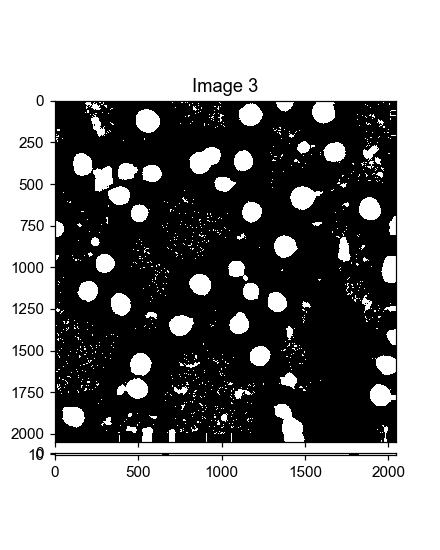

In [11]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask])

<IPython.core.display.Javascript object>


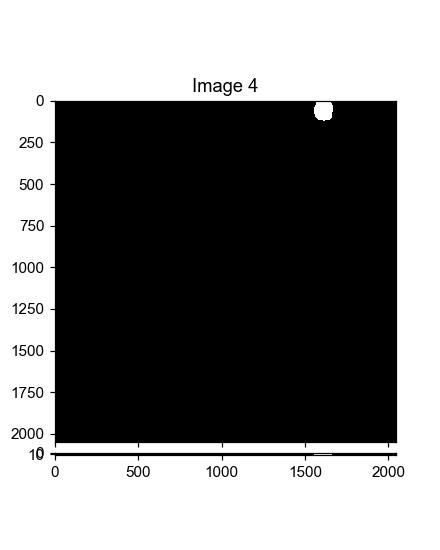

In [13]:
visual_tools.imshow_mark_3d_v2([polyt_im, corr_labels3d, new_labels, corr_labels3d==1])